<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/cours2024/Wavelet1DDenoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of wavelet denoising 1D
 use a simple hard thresholding technics
 compare with a simple hard cut on FFT spectrum or a Butterworth filter

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np

In [3]:
from pywt import swt,iswt,threshold  # wavelet lib.

# The signal

In [4]:
#signal
def f(x):
    return (np.piecewise(x,[x>=0, x>=0.05, x>=0.2,x>=0.55,x>=0.75, x>=0.9],
                [0, -30.,
                 lambda x: 10-10*np.sin((8*x + 0.8)*np.pi),
                 lambda x: 100-5*np.exp(4*x),
                 lambda x: -(80-5*np.exp(3*x)),
                 0.]))*2

In [5]:
np.arange(0,10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
Ns= 2**11
xvals = np.arange(0.,Ns)
signal = f(xvals/Ns)

In [7]:
Ns

2048

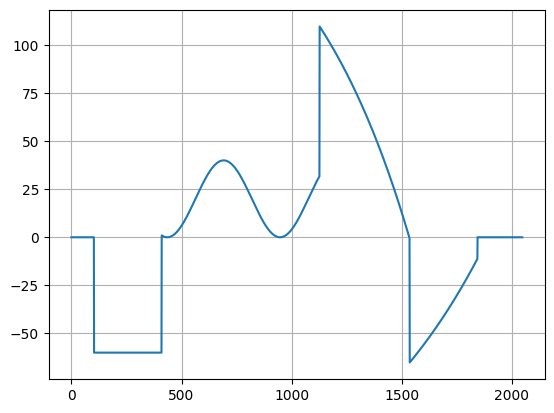

In [8]:
plot(xvals,signal)
grid()

# Decomposition using Stationnary Wavelet Transform

In [9]:
level=6    # level of decomposition (if None then get maximum depth)
wave="db2" # type of wavelet: db2 aka Daubechies 2  ("db1" is Haar)

In [10]:
# use stationnary wavelet decompostion
coeffs = swt(signal,wave,level=level,trim_approx=True) # [cAn, cDn, ..., cD2, cD1]

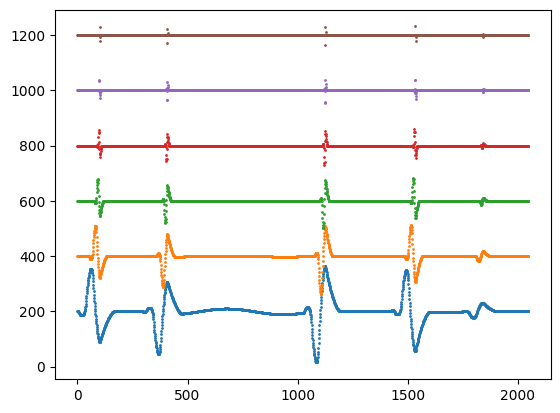

In [11]:
# show details coefficients on the same plot
for i in range(1,len(coeffs)):
    scatter(xvals,i*200 + coeffs[i],s=1)

# Noisy signal

In [12]:
#noisy observation
np.random.seed(4)
sigma = 5
noise = sigma*np.random.normal(size=(Ns,))
obs = signal + noise

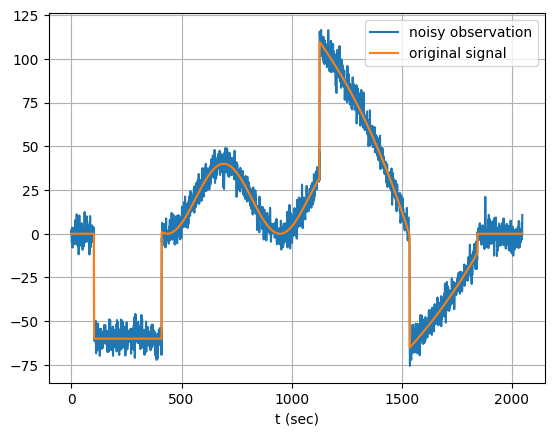

In [13]:
plot(xvals,obs,label="noisy observation")
plot(xvals,signal,label="original signal")
xlabel('t (sec)')
legend()
grid()

# Denoising using thresholding on details coeff.

In [14]:
# decompsition of noisy observation
coeffs_o = swt(obs,wave,level=level,trim_approx=True)

In [15]:
#get details coeffs CD1 to estimate the sigma via MAD (Median Absolute Deviation)
details = np.array([coeffs_o[i] for i in  range(1,len(coeffs_o))])
details = details.flatten()
sig_obs = 1.4826 * np.median(np.abs(coeffs_o[-1]))
print(f"observed sigma {sig_obs:.2f}, true sigma {sigma:.2f}")

observed sigma 5.02, true sigma 5.00


In [16]:
# Hard threshold applied to CDi: i=1,n
coeffs_o_th = coeffs_o.copy()
Threshold = sig_obs * np.sqrt(2*np.log(Ns))
for i in range(1,len(coeffs_o)):
    coeffs_o_th[i] = threshold(coeffs_o[i],Threshold,mode='hard',substitute=0)

In [17]:
n= 0
sum = 0
for  i in range(0,len(coeffs_o)):
  n += len(coeffs_o_th[i])
  sum += np.count_nonzero(coeffs_o_th[i])
print('fraction non-zero coeff',sum,n,sum/n)

fraction non-zero coeff 2880 14336 0.20089285714285715


In [18]:
# estimation of denoised signal
hat_signal = iswt(coeffs_o_th,wave)

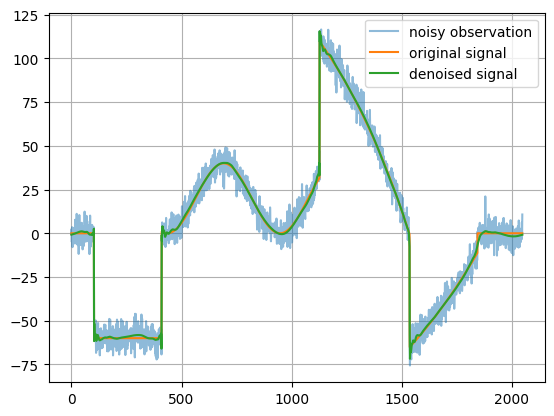

In [19]:
plot(xvals,obs,label="noisy observation",alpha=0.5)
plot(xvals,signal,label="original signal")
plot(xvals,hat_signal, label="denoised signal")
legend()
grid()

In [20]:
#metric to compare x wrt x_refernce
def metric(x,xref):
    return 10*np.log10(np.mean(xref**2)/np.mean((x-xref)**2))   # SNR

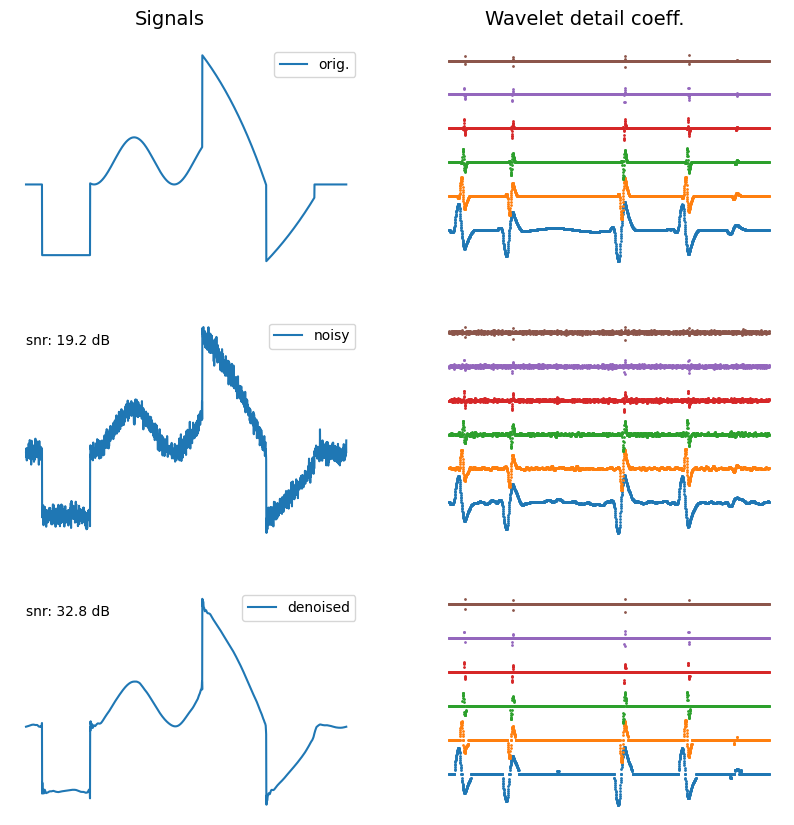

In [21]:
fig,axs=subplots(3,2,figsize=(10,10))
axs[0,0].plot(xvals,signal,label="orig.")
axs[1,0].plot(xvals,obs,label="noisy")
axs[2,0].plot(xvals,hat_signal,label="denoised")
axs[0,0].legend()
axs[1,0].legend()
axs[2,0].legend()

axs[1,0].text(0.2,100,f"snr: {metric(obs,signal):.3} dB")
axs[2,0].text(0.2,100,f"snr: {metric(hat_signal,signal):.3} dB")


for i in range(1,len(coeffs)):
    axs[0,1].scatter(xvals,i*200 + coeffs[i],s=1)
    axs[1,1].scatter(xvals,i*200 + coeffs_o[i],s=1)
    axs[2,1].scatter(xvals,i*200 + coeffs_o_th[i],s=1)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

fig.text(0.25,0.9,"Signals",fontsize=14);
fig.text(0.6,0.9,"Wavelet detail coeff.",fontsize=14);

# Fourier denoising using cut on power spectrum

In [22]:
from scipy.fft import rfft, irfft, rfftfreq

In [23]:
# estimation of the sigma using a constant part of the signal
mask1 = xvals<0.2*Ns
mask2 = xvals>0.05*Ns
mask3 = mask1&mask2
sigma_obs = 1.4826 *np.median(np.abs(obs[mask3]-np.median(obs[mask3])))
sigma_obs

4.692100963660298

In [24]:
noise_obs = sigma_obs*np.random.normal(size=(Ns,))

In [25]:
fft_signal = rfft(signal,norm='forward')
fft_obs =  rfft(obs,norm='forward')
fft_noise =  rfft(noise,norm='forward')
fft_noise_obs =  rfft(noise_obs,norm='forward')


In [41]:
dt = xvals[1]-xvals[0]

In [27]:
freqs = rfftfreq(n=Ns,d=dt)

In [28]:
fft_obs_cut  = fft_obs.copy()
#thresholding ex.
#thr = 0.25
#mask_th = np.abs(fft_obs_cut)<=thr
#fft_obs_cut[mask_th] = 0j
#linear projection
n_cut = 80
print(f"cut at {freqs[n_cut]:.2f} Hz")
fft_obs_cut[n_cut:]=0.

cut at 0.04 Hz


In [29]:
from fractions import Fraction as frac
def pi_axis_formatter(val, pos, denomlim=10, pi=r'\pi'):
    """
    format label properly
    for example: 0.6666 pi --> 2π/3
               : 0      pi --> 0
               : 0.50   pi --> π/2
    """
    minus = "-" if val < 0 else ""
    val = abs(val)
    ratio = frac(val/np.pi).limit_denominator(denomlim)
    n, d = ratio.numerator, ratio.denominator

    fmt2 = "%s" % d
    if n == 0:
        fmt1 = "0"
    elif n == 1:
        fmt1 = pi
    else:
        fmt1 = r"%s%s" % (n,pi)

    fmtstring = "$" + minus + (fmt1 if d == 1 else r"\frac{%s}{%s}" % (fmt1, fmt2)) + "$"

    return fmtstring

In [31]:
omegas = 2*np.pi*freqs

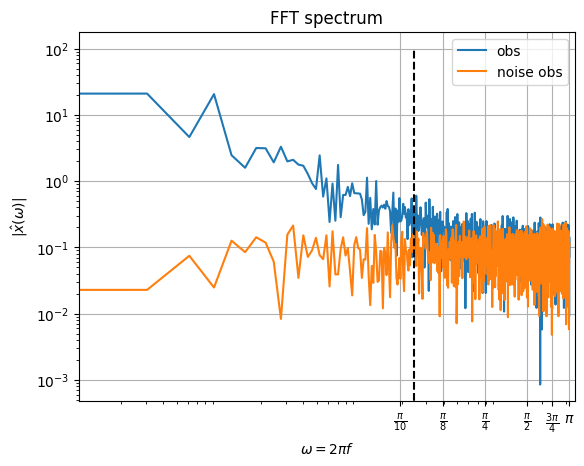

In [32]:
ax = plt.gca()
ax.plot(omegas,np.abs(fft_obs), label='obs')
ax.plot(omegas, np.abs(fft_noise_obs), label='noise obs')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("$\omega = 2\pi f$")
ax.set_ylabel("$|\hat{x}(\omega)|$")
plt.title("FFT spectrum")
ax.vlines(omegas[n_cut],0,1e2,color="k",ls="--")
#hlines(thr,0,Ns,color="k",ls="--")
# setting ticks labels
ax.xaxis.set_major_formatter(plt.FuncFormatter(pi_axis_formatter))
# setting ticks at proper numbers
ax.xaxis.set_major_locator(plt.MultipleLocator(base=np.pi/4))
x_extra_ticks = [np.pi/8,np.pi/16]
plt.xticks(list(plt.xticks()[0]) + x_extra_ticks)

ax.set_xlim([1e-3,np.pi+0.3])
plt.grid();
plt.legend();


In [33]:
sig_reco = irfft(fft_obs_cut,norm='forward')

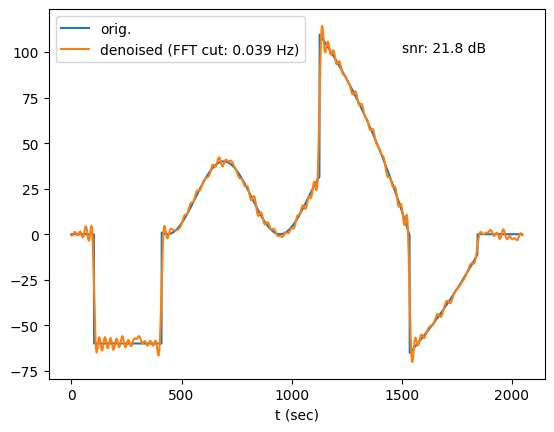

In [36]:
#plot(xvals,obs,label="noisy observation",alpha=0.5)
plot(xvals,signal,label="orig.")
plot(xvals,sig_reco, label=f"denoised (FFT cut: {freqs[n_cut]:.3f} Hz)")
legend()
text(1500,100,f"snr: {metric(sig_reco,signal):.1f} dB");
xlabel('t (sec)');

# Fourier denoising using filtering

In [37]:
# Signal filtering
from scipy.signal import  freqz, filtfilt, butter, bessel

In [38]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b,a= butter(order, normal_cutoff, btype='low', analog=False)
    return b,a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b,a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b,a,data)
    return y

def bessel_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b,a = bessel(order, normal_cutoff, btype='low', analog=False)
    return b,a

def bessel_lowpass_filter(data, cutoff, fs, order=5):
    b,a = bessel_lowpass(cutoff, fs, order=order)
    y = filtfilt(b,a, data)
    return y

In [104]:
fc = freqs[n_cut]
fs = 1/dt
order = 6 # filter order
print(f"Sampling freq. {fs} Hz, cut {fc:.3f} Hz")

Sampling freq. 1.0 Hz, cut 0.039 Hz


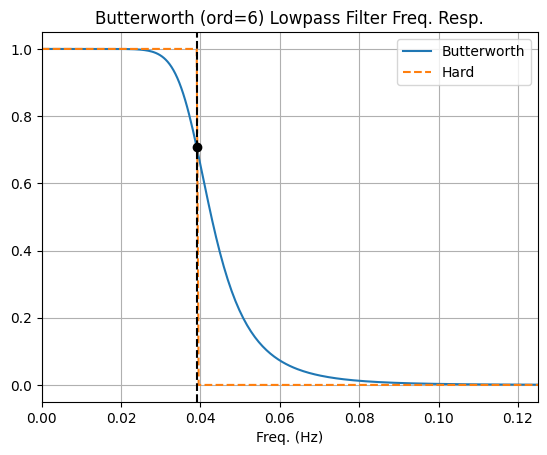

In [112]:
def compute_frequency_response(b_vals, a_vals, fs):
    """Compute the frequency response of a filter.

    Parameters
    ----------
    b_vals : 1d array
        B value filter coefficients for a filter.
    a_vals : 1d array
        A value filter coefficients for a filter.
    fs : float
        Sampling rate, in Hz.

    Returns
    -------
    f_db : 1d array
        Frequency vector corresponding to attenuation decibels, in Hz.
    db : 1d array
        Degree of attenuation for each frequency specified in `f_db`, in dB.
    """

    w_vals, h_vals = freqz(b_vals, a_vals, worN=1024)
    f_db = w_vals * fs / (2. * np.pi)
    db = 20 * np.log10(np.abs(h_vals))

    return f_db, db, np.abs(h_vals)

def hard(f,fc):
  return np.where(f<=fc,1.,0.)


b,a = butter_lowpass(fc, 1/fs, order=order)
w,h,habs = compute_frequency_response(b,a,1/fs)

plt.plot(w,habs,label='Butterworth')
plt.plot(w,hard(w,fc),ls="--", label="Hard")
plt.plot(fc, 0.5*np.sqrt(2), 'ko')
plt.axvline(fc, color='k',ls="--")
xlabel("Freq. (Hz)")
plt.title(f"Butterworth (ord={order}) Lowpass Filter Freq. Resp.")
xlim([0,fs/8])
legend()
grid();

In [102]:
signal__butter_filt = butter_lowpass_filter(obs, fc, 1/fs, order=order)


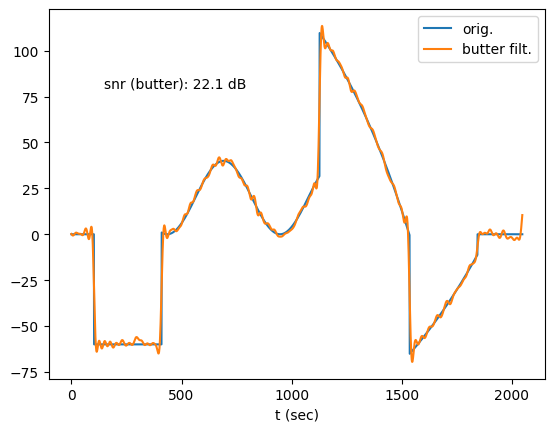

In [103]:
plot(xvals,signal,label="orig.")
plot(xvals,signal__butter_filt, label=f"butter filt.")
legend()
#text(150,100,f"snr (bessel): {metric(signal__bessel_filt,signal):.1f} dB");
text(150,80,f"snr (butter): {metric(signal__butter_filt,signal):.1f} dB");
xlabel('t (sec)');